# Crypto Spread Trading Analysis

## Setup

1. Create a `data/` folder in this directory
2. Copy the exchange data folders (`Binance/`, `OKX/`, `Coinbase/`) into `data/`
3. Install dependencies:
   ```bash
   uv sync
   ```

## Running the Analysis

### Option 1: Command Line (Recommended)

Run the optimization script directly for faster execution:

```bash
uv run python scripts/run_optimization.py --n-trials 50 --save-pickle --parallel
```

### Option 2: Jupyter Notebook

Open `crypto_spread_analysis.ipynb` to run the analysis interactively.

> **Note:** The notebook takes significantly longer to run than the command-line script.


More charts in the outputs/plots folder that i generated, but didn't included in the notebook. check out if interested. 

use claude to help with formatting/optimize the speed of the optimizer.

Since the submission only allowed for a ipynb data file, please check out the actual directory: https://github.com/amywangyx1022/qts_project for running the code. i will attach the optimizer code in the last cell, but the rest of module design is pretty long. 

# Crypto Spread Trading Analysis

## Performance Analysis

This notebook studies the performance of a crypto spread trading strategy across ETH-USDT pairs from three exchanges (Binance, Coinbase, OKX). We optimize the strategy parameters using Optuna and analyze the results.

Disclaimer: this is not a fancy optimizer, it's just standard practice from my firm that we should run the optimizer. I personally prefer a more precise answer than just directionally being correct. 

**Parameters to optimize:**
- `j` - Exit band level
- `g` - Entry band level (g > j)
- `l` - Stop-loss level (l > g)
- `N` - Rank for persistent spread
- `M` - Lookback window (M >= N)
- `ζ` - Trading cost (0.0 and 0.0001)


## 1. Setup & Data Loading

In [43]:
# Standard imports
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, 'src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Import our modules
from crypto_spread.config import (
    EXCHANGES, SPREAD_PAIRS, EMA_HALFLIFE_SECONDS,
    INITIAL_CAPITAL, STOP_CAPITAL, ZETA_VALUES,
    DATA_DIR, OUTPUT_DIR
)
from crypto_spread.data_loader import (
    load_and_align_all_data, get_spread_pair_data
)
from crypto_spread.signals import compute_all_signals
from crypto_spread.backtest import run_backtest, BacktestEngine
from crypto_spread.strategy import TradingStrategy, print_trades
from crypto_spread.optimizer import run_optimization, print_optimization_summary, get_best_trial_metrics

print("Modules loaded successfully!")
print(f"Exchanges: {EXCHANGES}")
print(f"Spread pairs: {SPREAD_PAIRS}")
print(f"EMA half-life: {EMA_HALFLIFE_SECONDS} seconds ({EMA_HALFLIFE_SECONDS/3600:.1f} hours)")

Modules loaded successfully!
Exchanges: ['Binance', 'Coinbase', 'OKX']
Spread pairs: [('Binance', 'Coinbase'), ('Binance', 'OKX'), ('Coinbase', 'OKX')]
EMA half-life: 10800 seconds (3.0 hours)


The data folder was setup so that if you drag the three folders from canvas to week2/data. you should be able to replicate the result

In [44]:
# Load and align all exchange data
# This filters to trades only (rec_type == 'T') and regularizes to 1-second intervals
print("Loading data from all exchanges...")
aligned_data = load_and_align_all_data(DATA_DIR)

print(f"\nAligned data shape: {aligned_data.shape}")
print(f"Columns: {aligned_data.columns.tolist()}")
print(f"\nTime range: {aligned_data['ts'].min()} to {aligned_data['ts'].max()}")
print(f"Total seconds: {len(aligned_data):,}")
print(f"\nFirst 10 rows:")
aligned_data.head(10)

Loading data from all exchanges...
Loading Binance...
  Loading 20250524.parquet... 2090724 trades
  Loading 20250525.parquet... 2556052 trades
  Loading 20250526.parquet... 2374458 trades
  Regularizing to 1-second intervals... 259198 rows
Loaded Binance: 259198 rows
Loading Coinbase...
  Loading 20250524.parquet... 8550 trades
  Loading 20250525.parquet... 12981 trades
  Regularizing to 1-second intervals... 172672 rows
Loaded Coinbase: 172672 rows
Loading OKX...
  Loading 20250524.parquet... 286466 trades
  Loading 20250525.parquet... 297363 trades
  Loading 20250526.parquet... 286596 trades
  Regularizing to 1-second intervals... 259199 rows
Loaded OKX: 259199 rows

Aligned data shape: (172672, 4)
Time range: 2025-05-24 00:00:06 to 2025-05-25 23:57:57

Aligned data shape: (172672, 4)
Columns: ['ts', 'price_Binance', 'price_Coinbase', 'price_OKX']

Time range: 2025-05-24 00:00:06 to 2025-05-25 23:57:57
Total seconds: 172,672

First 10 rows:


,ts,price_Binance,price_Coinbase,price_OKX
0,2025-05-24 00:00:06,2525.53,2525.57,2525.59
1,2025-05-24 00:00:07,2525.39,2525.75,2525.53
2,2025-05-24 00:00:08,2525.84,2525.75,2526.00
3,2025-05-24 00:00:09,2525.59,2525.75,2526.10
4,2025-05-24 00:00:10,2525.80,2525.75,2525.90
5,2025-05-24 00:00:11,2525.28,2525.75,2525.42
6,2025-05-24 00:00:12,2525.31,2525.75,2525.60
7,2025-05-24 00:00:13,2525.00,2525.75,2525.11
8,2025-05-24 00:00:14,2525.50,2525.75,2525.79
9,2025-05-24 00:00:15,2525.41,2525.79,2525.70


In [45]:
# Summary statistics for each exchange
print("Price statistics by exchange:")
for exchange in EXCHANGES:
    col = f'price_{exchange}'
    if col in aligned_data.columns:
        print(f"\n{exchange}:")
        print(aligned_data[col].describe())

Price statistics by exchange:

Binance:
count    172672.000000
mean       2529.725290
std          24.243836
min        2466.130000
25%        2511.380000
50%        2530.900000
75%        2552.290000
max        2575.850000
Name: price_Binance, dtype: float64

Coinbase:
count    172672.000000
mean       2529.751880
std          24.256617
min        2464.830000
25%        2511.440000
50%        2530.870000
75%        2552.220000
max        2576.070000
Name: price_Coinbase, dtype: float64

OKX:
count    172672.000000
mean       2529.769443
std          24.223873
min        2466.140000
25%        2511.410000
50%        2530.910000
75%        2552.350000
max        2575.880000
Name: price_OKX, dtype: float64


## 2. Spread Signal Analysis

For each spread pair, we calculate:
1. **Base spread**: $s^b = price_A - price_B$
2. **EMA** of base spread with 3-hour half-life
3. **Shifted spread**: $s = s^b - a$ (demeaned)
4. **Persistent levels**: $p^S$ (N-th smallest) and $p^L$ (N-th largest) over M observations

Processing Binance-Coinbase...
  Base spread: mean=-0.0266, std=1.1615
  Shifted spread: mean=-0.0040, std=1.1577
Processing Binance-OKX...
  Base spread: mean=-0.0442, std=0.2511
  Shifted spread: mean=0.0005, std=0.2432
Processing Coinbase-OKX...
  Base spread: mean=-0.0176, std=1.1854
  Shifted spread: mean=0.0045, std=1.1825


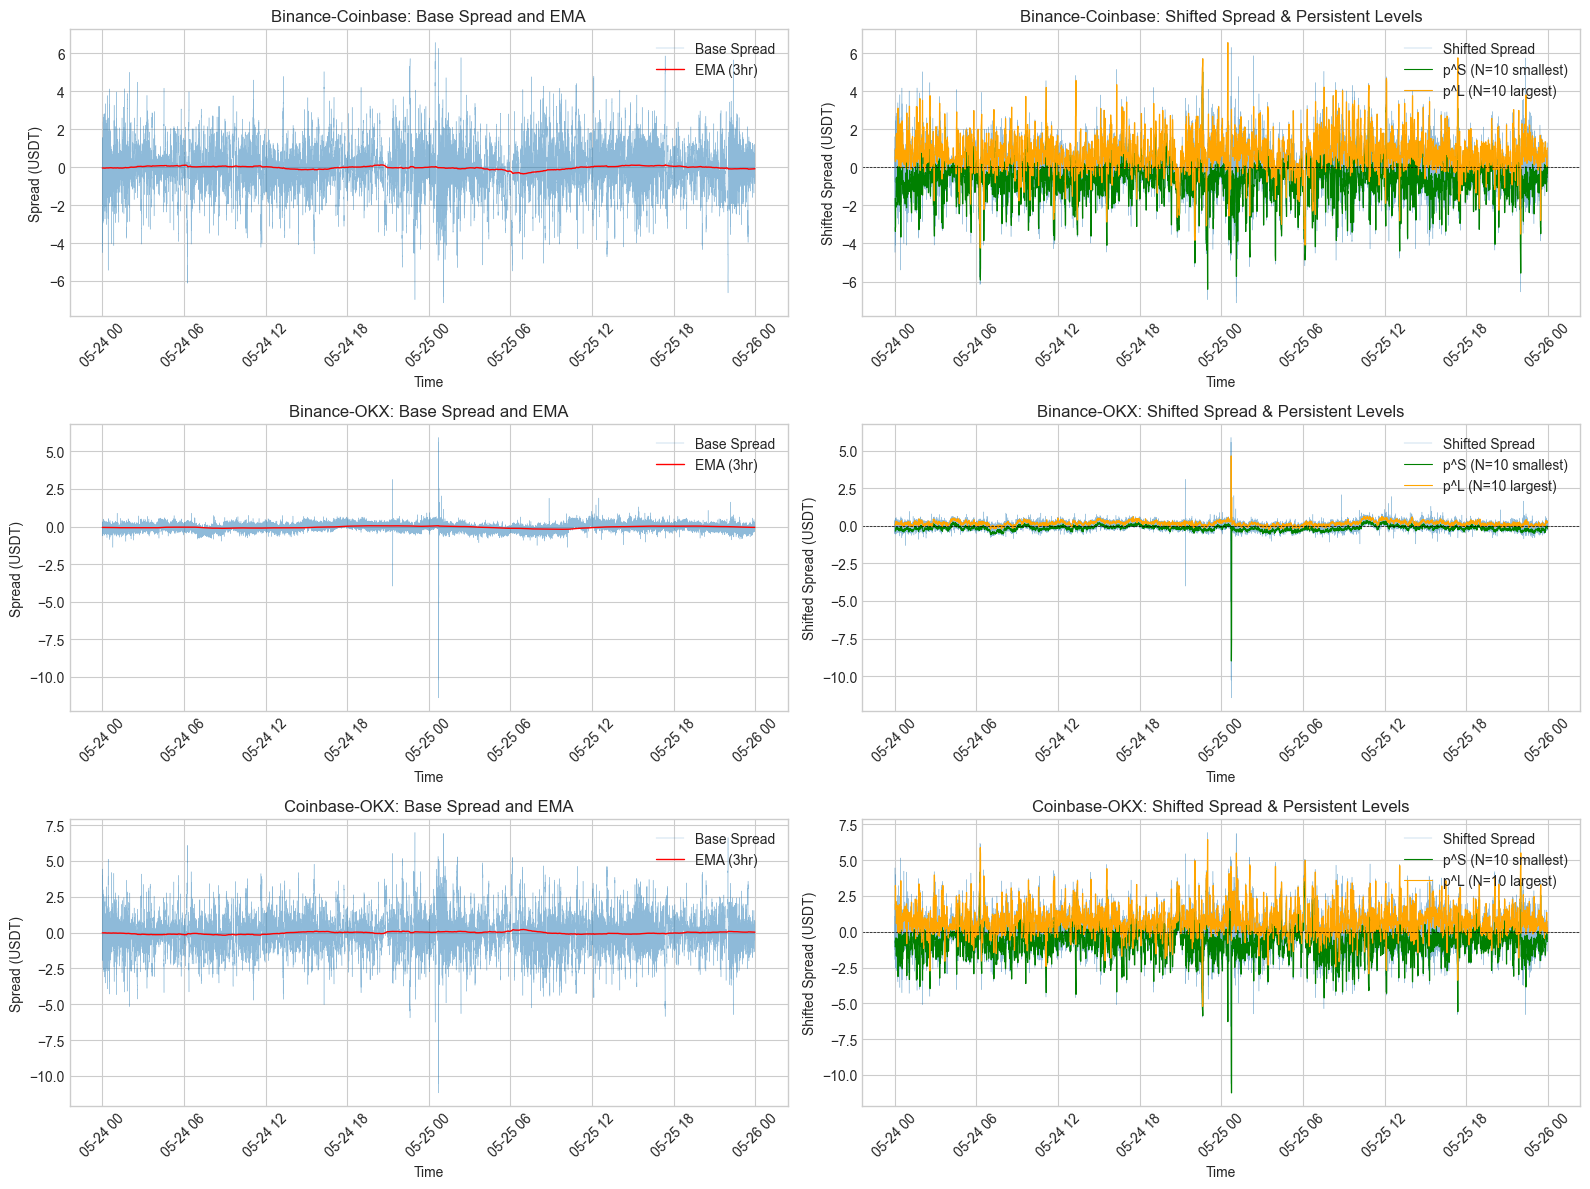

In [46]:
# Calculate and visualize spreads for all pairs
# Using sample N=10, M=100 for visualization
N_sample, M_sample = 10, 100

fig, axes = plt.subplots(len(SPREAD_PAIRS), 2, figsize=(16, 4*len(SPREAD_PAIRS)))

spread_data = {}

for i, (ex_a, ex_b) in enumerate(SPREAD_PAIRS):
    pair_name = f"{ex_a}-{ex_b}"
    print(f"Processing {pair_name}...")
    
    try:
        # Get price data
        pair_data = get_spread_pair_data(aligned_data, ex_a, ex_b)
        
        # Compute signals
        signals = compute_all_signals(
            pair_data['price_a'], 
            pair_data['price_b'], 
            N=N_sample, 
            M=M_sample
        )
        
        spread_data[pair_name] = {
            'pair_data': pair_data,
            'signals': signals
        }
        
        # Plot base spread and EMA
        ax1 = axes[i, 0]
        ax1.plot(pair_data['ts'], signals['base_spread'], alpha=0.5, linewidth=0.3, label='Base Spread')
        ax1.plot(pair_data['ts'], signals['ema'], color='red', linewidth=1, label='EMA (3hr)')
        ax1.set_title(f'{pair_name}: Base Spread and EMA')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Spread (USDT)')
        ax1.legend(loc='upper right')
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot shifted spread and persistent levels
        ax2 = axes[i, 1]
        ax2.plot(pair_data['ts'], signals['shifted_spread'], alpha=0.5, linewidth=0.3, label='Shifted Spread')
        ax2.plot(pair_data['ts'], signals['p_small'], color='green', linewidth=0.8, label=f'p^S (N={N_sample} smallest)')
        ax2.plot(pair_data['ts'], signals['p_large'], color='orange', linewidth=0.8, label=f'p^L (N={N_sample} largest)')
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
        ax2.set_title(f'{pair_name}: Shifted Spread & Persistent Levels')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Shifted Spread (USDT)')
        ax2.legend(loc='upper right')
        ax2.tick_params(axis='x', rotation=45)
        
        print(f"  Base spread: mean={signals['base_spread'].mean():.4f}, std={signals['base_spread'].std():.4f}")
        print(f"  Shifted spread: mean={signals['shifted_spread'].mean():.4f}, std={signals['shifted_spread'].std():.4f}")
        
    except Exception as e:
        print(f"  Error processing {pair_name}: {e}")

plt.tight_layout()
plt.savefig('outputs/plots/spread_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Strategy Demonstration

Run a single backtest with sample parameters to verify the trading logic:

**Trading Rules:**
- **SHORT** 1 ETH when $p^S > g$ (spread expensive)
- **LONG** 1 ETH when $p^L < -g$ (spread cheap)
- **Exit SHORT** when $p^S < j$ OR $p^S > l$ (stop loss)
- **Exit LONG** when $p^L > -j$ OR $p^L < -l$ (stop loss)

In [47]:
# Run a sample backtest
sample_pair = SPREAD_PAIRS[0]  # Binance-Coinbase
pair_name = f"{sample_pair[0]}-{sample_pair[1]}"

# Sample parameters
params = {
    'j': 0.5,   # Exit band
    'g': 1.5,   # Entry band
    'l': 3.0,   # Stop loss
    'N': 10,    # Rank
    'M': 100,   # Lookback
    'zeta': 0.0  # No trading costs
}

print(f"Running backtest for {pair_name} with parameters:")
for k, v in params.items():
    print(f"  {k} = {v}")

# Get data
pair_data = get_spread_pair_data(aligned_data, sample_pair[0], sample_pair[1])

# Run backtest
result = run_backtest(
    price_a=pair_data['price_a'],
    price_b=pair_data['price_b'],
    timestamps=pair_data['ts'],
    **params
)

print(f"\n{'='*50}")
print(f"Backtest Results")
print(f"{'='*50}")
print(f"Total trades: {result.num_trades}")
print(f"Trades per day: {result.trades_per_day:.1f}")
print(f"Sharpe ratio: {result.sharpe_ratio:.4f}")
print(f"Total return: {result.total_return*100:.4f}%")
print(f"Max drawdown: {result.max_drawdown*100:.2f}%")
print(f"Win rate: {result.win_rate*100:.1f}%")
print(f"Final capital: ${result.final_capital:,.2f}")
print(f"Stop loss events: {result.stop_loss_count}")

# Print trades for verification
print_trades(result.trades, max_trades=20)

Running backtest for Binance-Coinbase with parameters:
  j = 0.5
  g = 1.5
  l = 3.0
  N = 10
  M = 100
  zeta = 0.0

Backtest Results
Total trades: 19
Trades per day: 9.5
Sharpe ratio: 38.1104
Total return: 0.0604%
Max drawdown: 0.02%
Win rate: 89.5%
Final capital: $80,048.32
Stop loss events: 2

TRADE LOG (19 of 19 trades)
   # Side   Entry Time           Exit Time               Entry A    Entry B     Exit A     Exit B        PnL Exit Reason 
------------------------------------------------------------------------------------------------------------------------
   1 SHORT  2025-05-24 02:34:02  2025-05-24 02:34:52     2539.90    2536.30    2539.60    2539.63     3.6300 NORMAL      
   2 LONG   2025-05-24 02:53:30  2025-05-24 02:54:00     2538.50    2542.06    2538.35    2537.82     4.0900 NORMAL      
   3 SHORT  2025-05-24 03:40:08  2025-05-24 03:41:13     2550.20    2547.93    2548.41    2548.53     2.3900 NORMAL      
   4 LONG   2025-05-24 04:44:28  2025-05-24 04:45:39     2557.08

In [48]:
result.trades

[Trade(side=<PositionSide.SHORT: 'SHORT'>, entry_time=Timestamp('2025-05-24 02:34:02'), exit_time=Timestamp('2025-05-24 02:34:52'), entry_price_a=np.float64(2539.9), entry_price_b=np.float64(2536.3), exit_price_a=np.float64(2539.6), exit_price_b=np.float64(2539.63), entry_spread=np.float64(-0.06147623945199199), exit_spread=np.float64(-0.06147623945199199), pnl=np.float64(3.630000000000109), exit_reason=<ExitReason.NORMAL: 'NORMAL'>, size_eth=1.0),
 Trade(side=<PositionSide.LONG: 'LONG'>, entry_time=Timestamp('2025-05-24 02:53:30'), exit_time=Timestamp('2025-05-24 02:54:00'), entry_price_a=np.float64(2538.5), entry_price_b=np.float64(2542.06), exit_price_a=np.float64(2538.35), exit_price_b=np.float64(2537.82), entry_spread=np.float64(0.16191143847998266), exit_spread=np.float64(0.16191143847998266), pnl=np.float64(4.089999999999691), exit_reason=<ExitReason.NORMAL: 'NORMAL'>, size_eth=1.0),
 Trade(side=<PositionSide.SHORT: 'SHORT'>, entry_time=Timestamp('2025-05-24 03:40:08'), exit_tim

## 4. Parameter Optimization

Using Optuna with TPE (Tree-structured Parzen Estimator) sampler to maximize Sharpe ratio.

We run optimization for:
- Each spread pair (Binance-Coinbase, Binance-OKX, Coinbase-OKX)
- Each trading cost level (ζ=0.0, ζ=0.0001)

In [68]:
# Optimization settings
N_TRIALS = 50  # Number of trials per optimization 
ZETA_TEST = [0.0, 0.0001]  # Trading cost levels

# Control flag: set to True to run optimization in-notebook, False to load from pickle
RUN_ANALYSIS = False

# Store all results
optimization_results = {}
best_backtest_results = {}

print(f"Running optimization with {N_TRIALS} trials for each configuration...")
print(f"Spread pairs: {SPREAD_PAIRS}")
print(f"Zeta values: {ZETA_TEST}")
print(f"Total optimizations: {len(SPREAD_PAIRS) * len(ZETA_TEST)}")
print(f"RUN_ANALYSIS: {RUN_ANALYSIS}")
print()

Running optimization with 50 trials for each configuration...
Spread pairs: [('Binance', 'Coinbase'), ('Binance', 'OKX'), ('Coinbase', 'OKX')]
Zeta values: [0.0, 0.0001]
Total optimizations: 6
RUN_ANALYSIS: False



In [69]:
# Load pre-computed optimization results from pickle (when RUN_ANALYSIS=False)
# To generate results, run:
#   uv run python scripts/run_optimization.py --n-trials 50 --save-pickle --parallel

if not RUN_ANALYSIS:
    import pickle
    from pathlib import Path
    from dataclasses import dataclass
    from typing import Optional, Dict, Any

    # Wrapper class to provide OptimizationResult-like interface for dict data (from parallel mode)
    @dataclass
    class OptimizationResultWrapper:
        """Wrapper to make dict results look like OptimizationResult objects."""
        best_params: Dict[str, Any]
        best_value: float
        n_completed: int
        n_pruned: int
        metrics: Dict[str, Any]
        study: Optional[Any] = None  # Not available in parallel mode
        
        @classmethod
        def from_dict(cls, d: dict) -> 'OptimizationResultWrapper':
            return cls(
                best_params=d.get("best_params", {}),
                best_value=d.get("best_value", 0.0),
                n_completed=d.get("n_completed", 0),
                n_pruned=d.get("n_pruned", 0),
                metrics=d.get("metrics", {}),
                study=None,
            )

    pickle_path = Path('outputs/results/optimization_results.pkl')
    if pickle_path.exists():
        with open(pickle_path, 'rb') as f:
            loaded_data = pickle.load(f)
        
        # Convert keys from ((ex_a, ex_b), zeta) to (pair_name, zeta) format
        optimization_results = {}
        best_backtest_results = {}
        
        for key, opt_result in loaded_data['optimization_results'].items():
            spread_pair, zeta = key
            pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
            
            # Handle both dict format (parallel mode) and OptimizationResult format (sequential mode)
            if isinstance(opt_result, dict):
                # Parallel mode: wrap dict in OptimizationResultWrapper
                optimization_results[(pair_name, zeta)] = OptimizationResultWrapper.from_dict(opt_result)
            else:
                # Sequential mode: use OptimizationResult directly
                optimization_results[(pair_name, zeta)] = opt_result
        
        for key, backtest_result in loaded_data['backtest_results'].items():
            spread_pair, zeta = key
            pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
            best_backtest_results[(pair_name, zeta)] = backtest_result
        
        print(f"Loaded optimization results from {pickle_path}")
        print(f"  Optimization results: {len(optimization_results)} configurations")
        print(f"  Backtest results: {len(best_backtest_results)} configurations")
        
        # Check if parallel mode was used
        sample_result = next(iter(optimization_results.values()))
        if isinstance(sample_result, OptimizationResultWrapper):
            print(f"  Note: Results were generated in parallel mode (Study objects not available)")
    else:
        print(f"No pickle file found at {pickle_path}")
        print(f"Run: uv run python scripts/run_optimization.py --n-trials 50 --save-pickle --parallel")
        print(f"Or set RUN_ANALYSIS=True in the cell above to run optimization in-notebook.")
else:
    print("RUN_ANALYSIS=True: Will run optimization in next cell")

Loaded optimization results from outputs/results/optimization_results.pkl
  Optimization results: 6 configurations
  Backtest results: 6 configurations
  Note: Results were generated in parallel mode (Study objects not available)


In [70]:
# Run optimization for each pair and zeta value (only when RUN_ANALYSIS=True)
if RUN_ANALYSIS:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    for spread_pair in SPREAD_PAIRS:
        pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
        
        # Get price data
        try:
            pair_data = get_spread_pair_data(aligned_data, spread_pair[0], spread_pair[1])
        except Exception as e:
            print(f"Skipping {pair_name}: {e}")
            continue
        
        for zeta in ZETA_TEST:
            print(f"\n{'='*60}")
            print(f"Optimizing: {pair_name}, zeta={zeta}")
            print(f"{'='*60}")
            
            # Run optimization
            opt_result = run_optimization(
                price_a=pair_data['price_a'],
                price_b=pair_data['price_b'],
                timestamps=pair_data['ts'],
                spread_pair=spread_pair,
                zeta=zeta,
                n_trials=N_TRIALS,
                seed=42,
                show_progress=True,
            )
            
            optimization_results[(pair_name, zeta)] = opt_result
            
            # Print summary
            print_optimization_summary(opt_result)
            
            # Run backtest with best parameters
            if opt_result.n_completed > 0:
                best_params = opt_result.best_params
                best_result = run_backtest(
                    price_a=pair_data['price_a'],
                    price_b=pair_data['price_b'],
                    timestamps=pair_data['ts'],
                    j=best_params['j'],
                    g=best_params['g'],
                    l=best_params['l'],
                    N=best_params['N'],
                    M=best_params['M'],
                    zeta=zeta,
                )
                best_backtest_results[(pair_name, zeta)] = best_result
else:
    print("Skipping optimization (RUN_ANALYSIS=False)")
    print("Results loaded from pickle in previous cell.")
    print()
    print("To run optimization in notebook, set RUN_ANALYSIS=True in cell above.")
    print("Or run from command line:")
    print("  uv run python scripts/run_optimization.py --n-trials 50 --save-pickle --parallel")

Skipping optimization (RUN_ANALYSIS=False)
Results loaded from pickle in previous cell.

To run optimization in notebook, set RUN_ANALYSIS=True in cell above.
Or run from command line:
  uv run python scripts/run_optimization.py --n-trials 50 --save-pickle --parallel


In [71]:
# Seeded re-search: If one zeta found better params, search that region for the other
print("\n" + "="*60)
print("SEEDED RE-OPTIMIZATION")
print("="*60)

def run_seeded_optimization(pair_data, spread_pair, zeta, seed_params, n_trials=30):
    """Run optimization with search centered around seed parameters."""
    import optuna
    from crypto_spread.config import MIN_TRADES_PER_DAY

    def objective(trial):
        # Search in a neighborhood around seed params
        j = trial.suggest_float("j", max(0.01, seed_params['j'] * 0.5), seed_params['j'] * 2.0)

        g_min = j + 0.01
        g_center = seed_params['g']
        g = trial.suggest_float("g", max(g_min, g_center * 0.5), g_center * 2.0)

        l_min = g + 0.01
        l_center = seed_params['l']
        l = trial.suggest_float("l", max(l_min, l_center * 0.5), l_center * 2.0)

        N_center = seed_params['N']
        N = trial.suggest_int("N", max(1, N_center - 30), min(100, N_center + 30))

        M_center = seed_params['M']
        M = trial.suggest_int("M", max(N, M_center - 100), min(1000, M_center + 100))

        try:
            result = run_backtest(
                price_a=pair_data['price_a'],
                price_b=pair_data['price_b'],
                timestamps=pair_data['ts'],
                j=j, g=g, l=l, N=N, M=M,
                zeta=zeta,
            )

            if result.trades_per_day < MIN_TRADES_PER_DAY:
                raise optuna.TrialPruned()

            trial.set_user_attr("max_drawdown", result.max_drawdown)
            trial.set_user_attr("total_return", result.total_return)
            trial.set_user_attr("win_rate", result.win_rate)
            trial.set_user_attr("trades_per_day", result.trades_per_day)
            trial.set_user_attr("stop_loss_count", result.stop_loss_count)

            return result.sharpe_ratio
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    return study

for spread_pair in SPREAD_PAIRS:
    pair_name = f"{spread_pair[0]}-{spread_pair[1]}"

    result_0 = optimization_results.get((pair_name, 0.0))
    result_1 = optimization_results.get((pair_name, 0.0001))

    if result_0 is None or result_1 is None:
        continue

    sharpe_0 = result_0.best_value if result_0.n_completed > 0 else float('-inf')
    sharpe_1 = result_1.best_value if result_1.n_completed > 0 else float('-inf')

    if sharpe_1 > sharpe_0 and result_1.n_completed > 0:
        seed_params = result_1.best_params
        print(f"\n{pair_name}: zeta=0.0001 found better params (Sharpe {sharpe_1:.2f} vs {sharpe_0:.2f})")
        print(f"  Seed params: j={seed_params['j']:.4f}, g={seed_params['g']:.4f}")
        print(f"  Re-searching that region for zeta=0.0...")

        pair_data = get_spread_pair_data(aligned_data, spread_pair[0], spread_pair[1])
        study = run_seeded_optimization(pair_data, spread_pair, zeta=0.0, seed_params=seed_params, n_trials=30)

        if len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]) > 0:
            new_sharpe = study.best_value
            new_params = study.best_params

            print(f"  Original zeta=0.0: Sharpe {sharpe_0:.4f}")
            print(f"  Re-searched zeta=0.0: Sharpe {new_sharpe:.4f}")
            print(f"  zeta=0.0001: Sharpe {sharpe_1:.4f}")

            # Update results
            result_corrected = run_backtest(
                price_a=pair_data['price_a'],
                price_b=pair_data['price_b'],
                timestamps=pair_data['ts'],
                **new_params,
                zeta=0.0,
            )
            best_backtest_results[(pair_name, 0.0)] = result_corrected

            # Create wrapper for optimization_results
            from dataclasses import dataclass
            @dataclass
            class ResultWrapper:
                best_params: dict
                best_value: float
                n_completed: int
                n_pruned: int
                metrics: dict
                study: object = None

            optimization_results[(pair_name, 0.0)] = ResultWrapper(
                best_params=new_params,
                best_value=new_sharpe,
                n_completed=len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]),
                n_pruned=len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]),
                metrics={
                    'total_return': result_corrected.total_return,
                    'max_drawdown': result_corrected.max_drawdown,
                    'win_rate': result_corrected.win_rate,
                    'trades_per_day': result_corrected.trades_per_day,
                    'stop_loss_count': result_corrected.stop_loss_count,
                },
                study=study,
            )

print("\n" + "="*60)


SEEDED RE-OPTIMIZATION



## 5. Results & Analysis
### 5.1 Best Parameters Summary

In [72]:
# Create summary table
summary_data = []

for (pair_name, zeta), opt_result in optimization_results.items():
    if opt_result.n_completed > 0:
        # Get metrics: use pre-computed metrics if study not available (parallel mode)
        if opt_result.study is not None:
            metrics = get_best_trial_metrics(opt_result.study)
        else:
            metrics = opt_result.metrics  # From parallel mode wrapper
        
        backtest = best_backtest_results.get((pair_name, zeta))
        
        row = {
            'Spread Pair': pair_name,
            'Zeta': zeta,
            'j (exit)': opt_result.best_params.get('j', 0),
            'g (entry)': opt_result.best_params.get('g', 0),
            'l (stop)': opt_result.best_params.get('l', 0),
            'N': opt_result.best_params.get('N', 0),
            'M': opt_result.best_params.get('M', 0),
            'Sharpe': opt_result.best_value,
            'Return (%)': metrics.get('total_return', 0) * 100,
            'Max DD (%)': metrics.get('max_drawdown', 0) * 100,
            'Win Rate (%)': metrics.get('win_rate', 0) * 100,
            'Trades/Day': metrics.get('trades_per_day', 0),
            'Stop Losses': metrics.get('stop_loss_count', 0),
        }
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("Best Parameters and Performance Summary")
print("="*100)
display(summary_df.round(4))

Best Parameters and Performance Summary


,Spread Pair,Zeta,j (exit),g (entry),l (stop),N,M,Sharpe,Return (%),Max DD (%),Win Rate (%),Trades/Day,Stop Losses
0,Binance-Coinbase,0.0000,0.6797,0.7645,12.3031,59,60,366.5909,1.7423,0.0135,91.5009,553.0,0
1,Coinbase-OKX,0.0000,0.0224,0.1649,19.7607,8,61,383.5599,1.4228,0.0072,100.0000,364.5,0
2,Coinbase-OKX,0.0001,0.0466,0.8774,5.7728,80,190,145.9489,0.3241,0.0145,100.0000,53.0,0
3,Binance-OKX,0.0001,0.0493,0.3095,3.0620,5,33,13.6038,0.0223,0.0116,53.8462,6.5,1
4,Binance-Coinbase,0.0001,0.8024,0.9015,7.1478,43,153,119.5850,0.2446,0.0097,98.0000,50.0,0
5,Binance-OKX,0.0000,0.0616,0.2621,5.2475,22,25,76.6531,0.1144,0.0174,99.5652,115.0,1


All the pairs have some crazy high sharpe ratio (transformed from hourly pnl curve) which makes sense as this is a cross exchange arbitrage. From the results it looks like Binance - OKX pair has the lowest sharpe ratio, whereas other exchange pairs' inefficiency is more prominent and lucrative.

### 5.2 Effect of Trading Costs

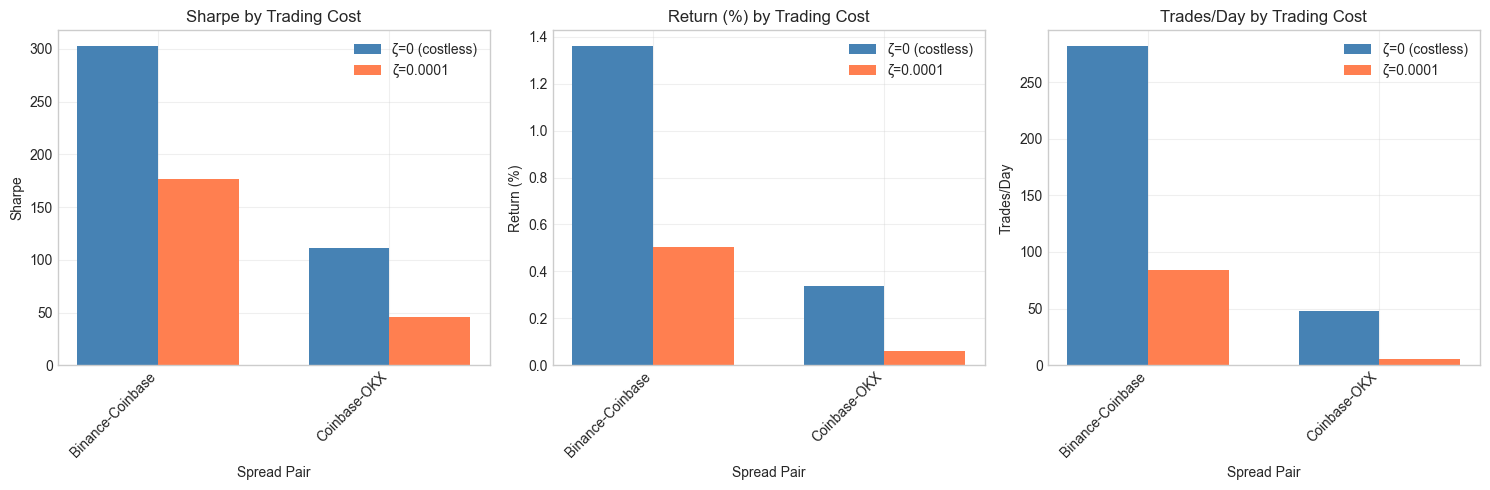


Trading Cost Impact Analysis:

Binance-Coinbase:
  Sharpe change: 302.4473 → 176.2049 (-41.7%)
  Return change: 1.3593% → 0.5030%

Coinbase-OKX:
  Sharpe change: 111.2117 → 45.8022 (-58.8%)
  Return change: 0.3371% → 0.0627%


In [56]:
# Compare zeta=0 vs zeta=0.0001
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_compare = ['Sharpe', 'Return (%)', 'Trades/Day']

for i, metric in enumerate(metrics_to_compare):
    ax = axes[i]
    
    # Pivot data for plotting
    pivot_data = summary_df.pivot(index='Spread Pair', columns='Zeta', values=metric)
    
    x = np.arange(len(pivot_data))
    width = 0.35
    
    if 0.0 in pivot_data.columns:
        bars1 = ax.bar(x - width/2, pivot_data[0.0], width, label='ζ=0 (costless)', color='steelblue')
    if 0.0001 in pivot_data.columns:
        bars2 = ax.bar(x + width/2, pivot_data[0.0001], width, label='ζ=0.0001', color='coral')
    
    ax.set_xlabel('Spread Pair')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} by Trading Cost')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/trading_cost_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Analysis
print("\nTrading Cost Impact Analysis:")
print("="*60)
for pair in summary_df['Spread Pair'].unique():
    pair_data = summary_df[summary_df['Spread Pair'] == pair]
    if len(pair_data) == 2:
        zeta0 = pair_data[pair_data['Zeta'] == 0.0].iloc[0]
        zeta1 = pair_data[pair_data['Zeta'] == 0.0001].iloc[0]
        print(f"\n{pair}:")
        print(f"  Sharpe change: {zeta0['Sharpe']:.4f} → {zeta1['Sharpe']:.4f} ({(zeta1['Sharpe']-zeta0['Sharpe'])/abs(zeta0['Sharpe'])*100:.1f}%)")
        print(f"  Return change: {zeta0['Return (%)']:.4f}% → {zeta1['Return (%)']:.4f}%")

### 5.3 Equity Curves Comparison

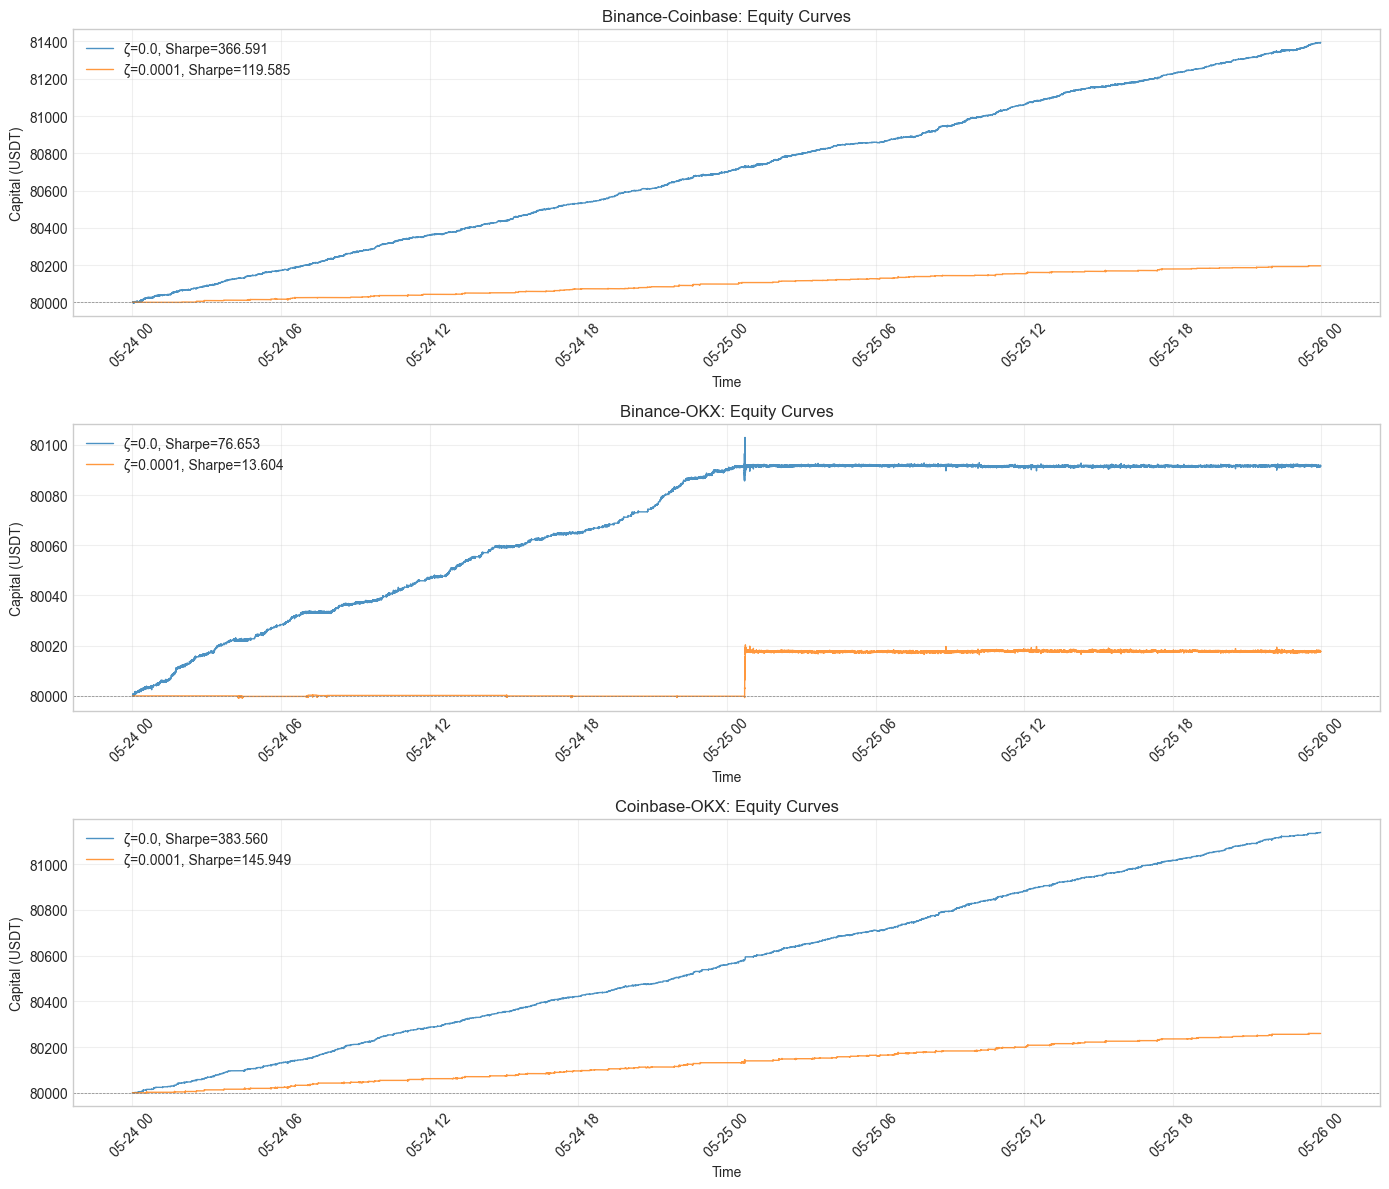

In [74]:
# Plot equity curves for all configurations
fig, axes = plt.subplots(len(SPREAD_PAIRS), 1, figsize=(14, 4*len(SPREAD_PAIRS)))

if len(SPREAD_PAIRS) == 1:
    axes = [axes]

for i, (ex_a, ex_b) in enumerate(SPREAD_PAIRS):
    pair_name = f"{ex_a}-{ex_b}"
    ax = axes[i]
    
    for zeta in ZETA_TEST:
        key = (pair_name, zeta)
        if key in best_backtest_results:
            result = best_backtest_results[key]
            label = f'ζ={zeta}, Sharpe={optimization_results[key].best_value:.3f}'
            ax.plot(result.equity_curve.index, result.equity_curve.values, 
                   linewidth=1, label=label, alpha=0.8)
    
    ax.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', linewidth=0.5)
    ax.set_title(f'{pair_name}: Equity Curves')
    ax.set_xlabel('Time')
    ax.set_ylabel('Capital (USDT)')
    ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/equity_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

Binance-OKX pair from the chart has some weird kinks, which are illustrated in the spread chart.given the fact that coinbase-okx pair also exhibit similar trends, i'm comfortable with this data being real tradable set. 

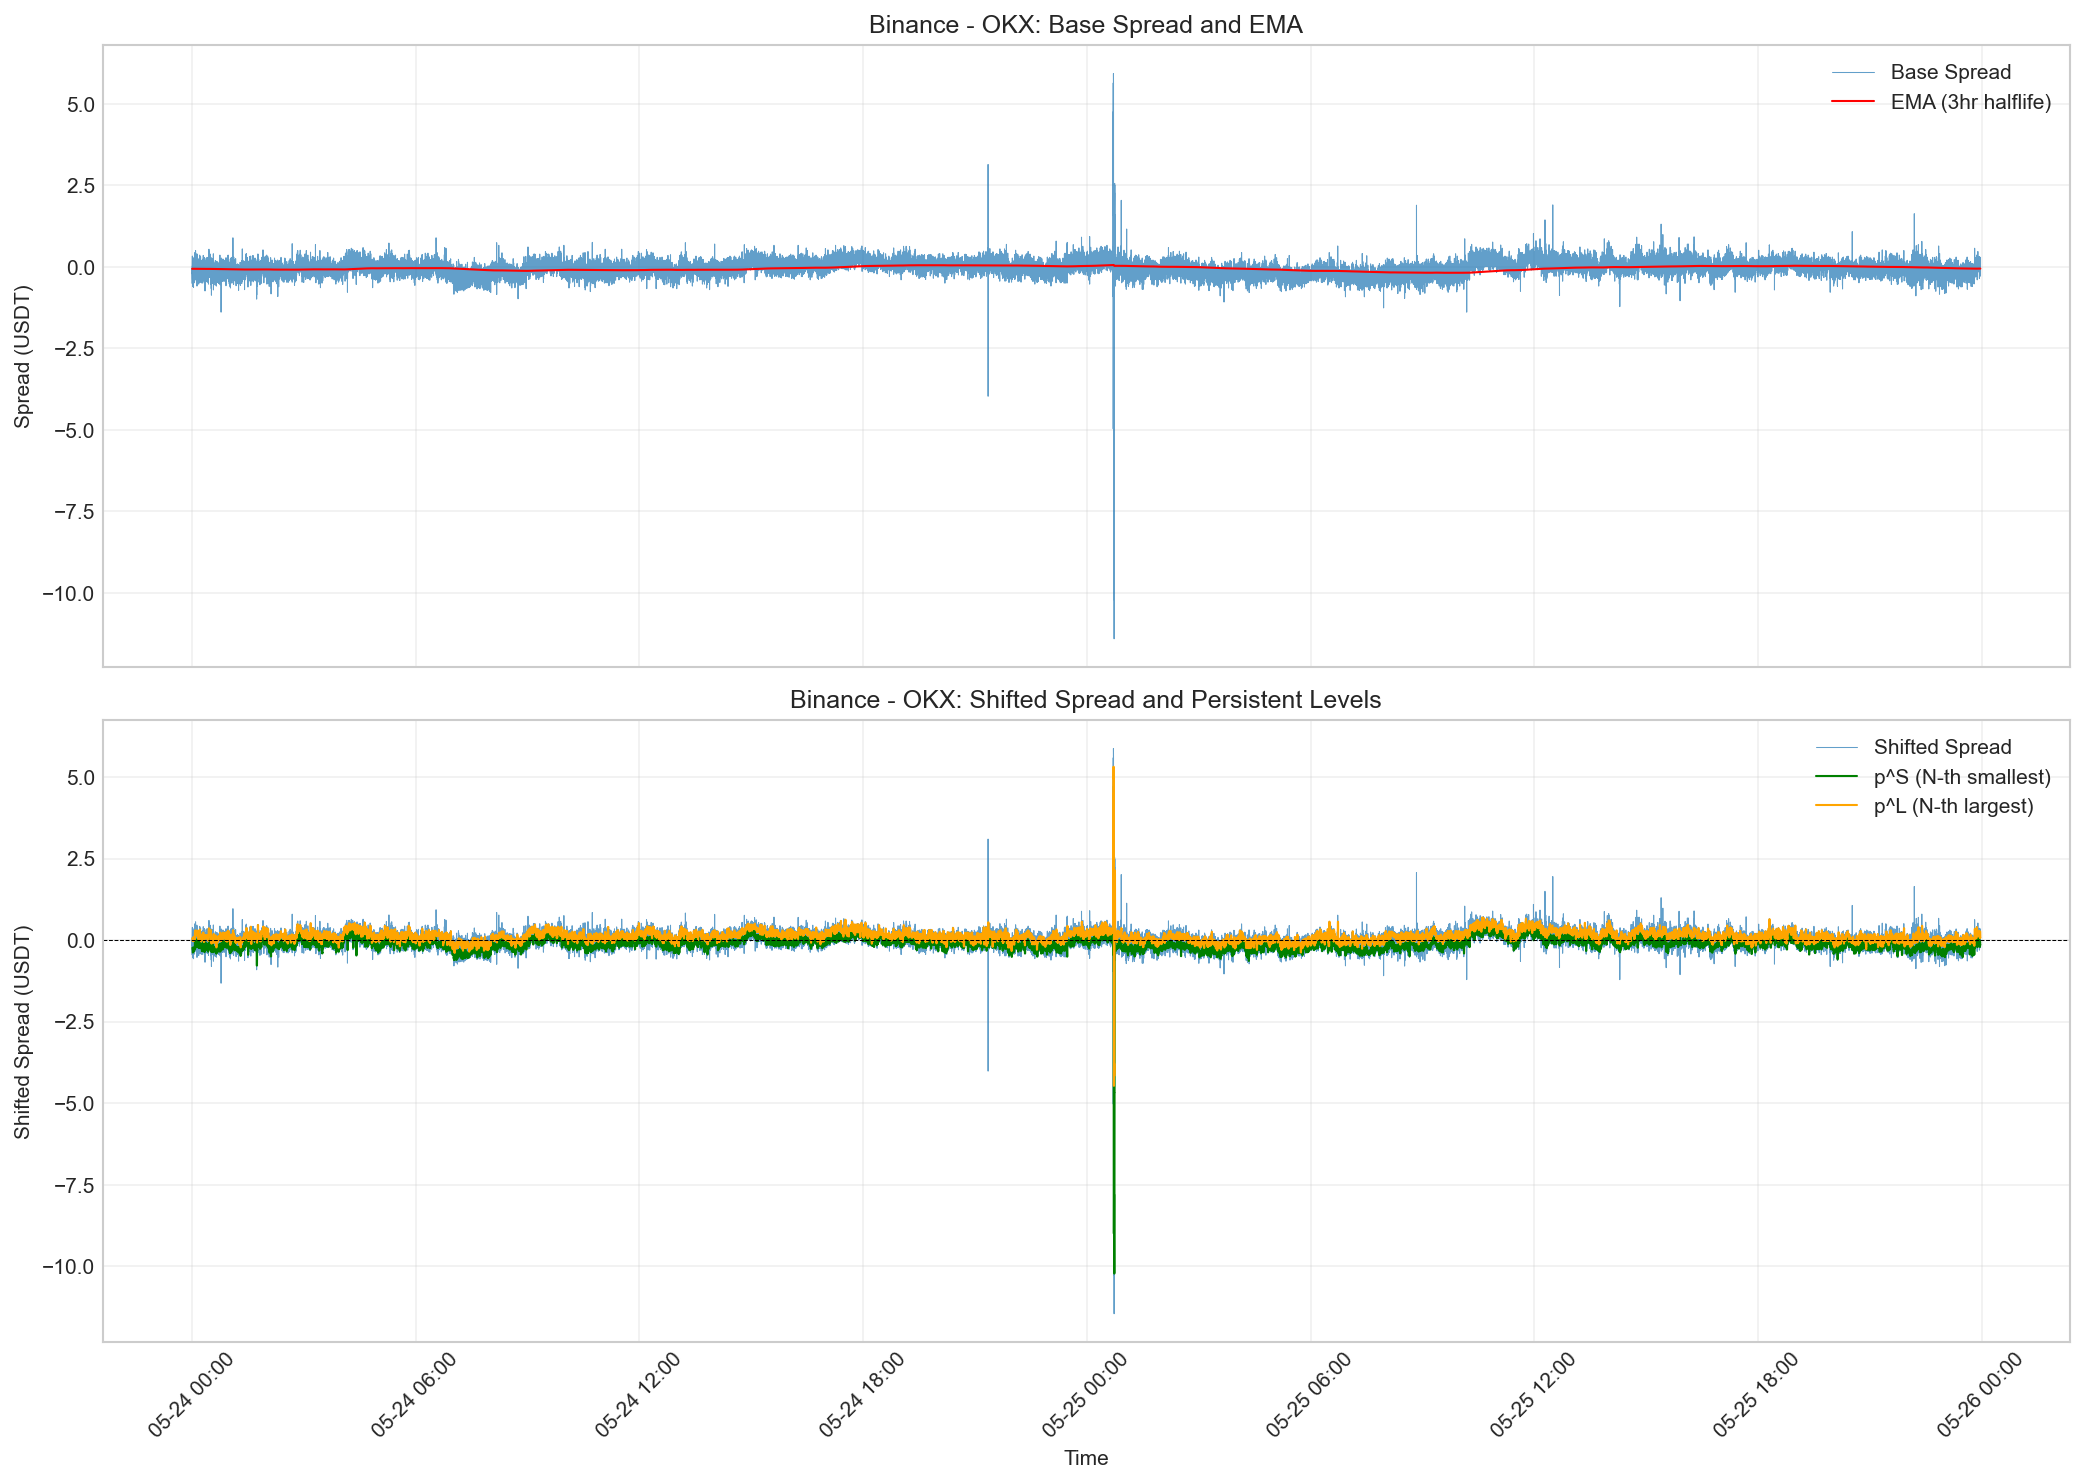

In [77]:
from IPython.display import Image, display                                                                    
display(Image(filename='outputs/plots/spread_signals_Binance_OKX.png'))          

In terms of trade distirbution, most of the trades are small profit ones, which makes sense since most of the pricing difference is within the 10 dollar ranges.

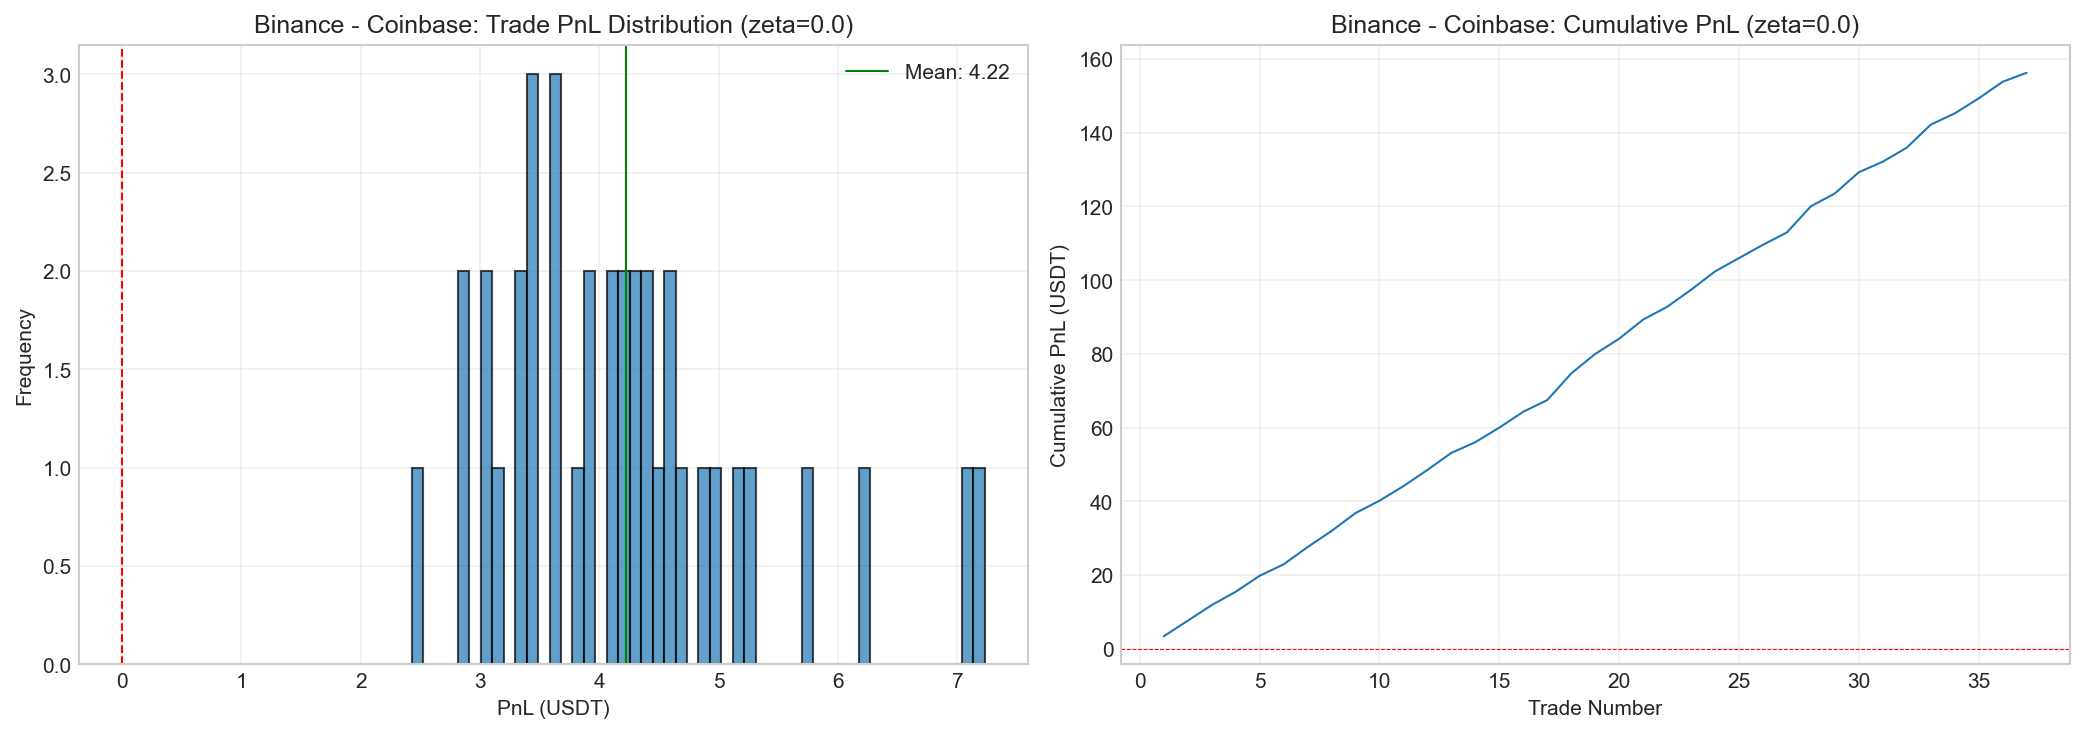

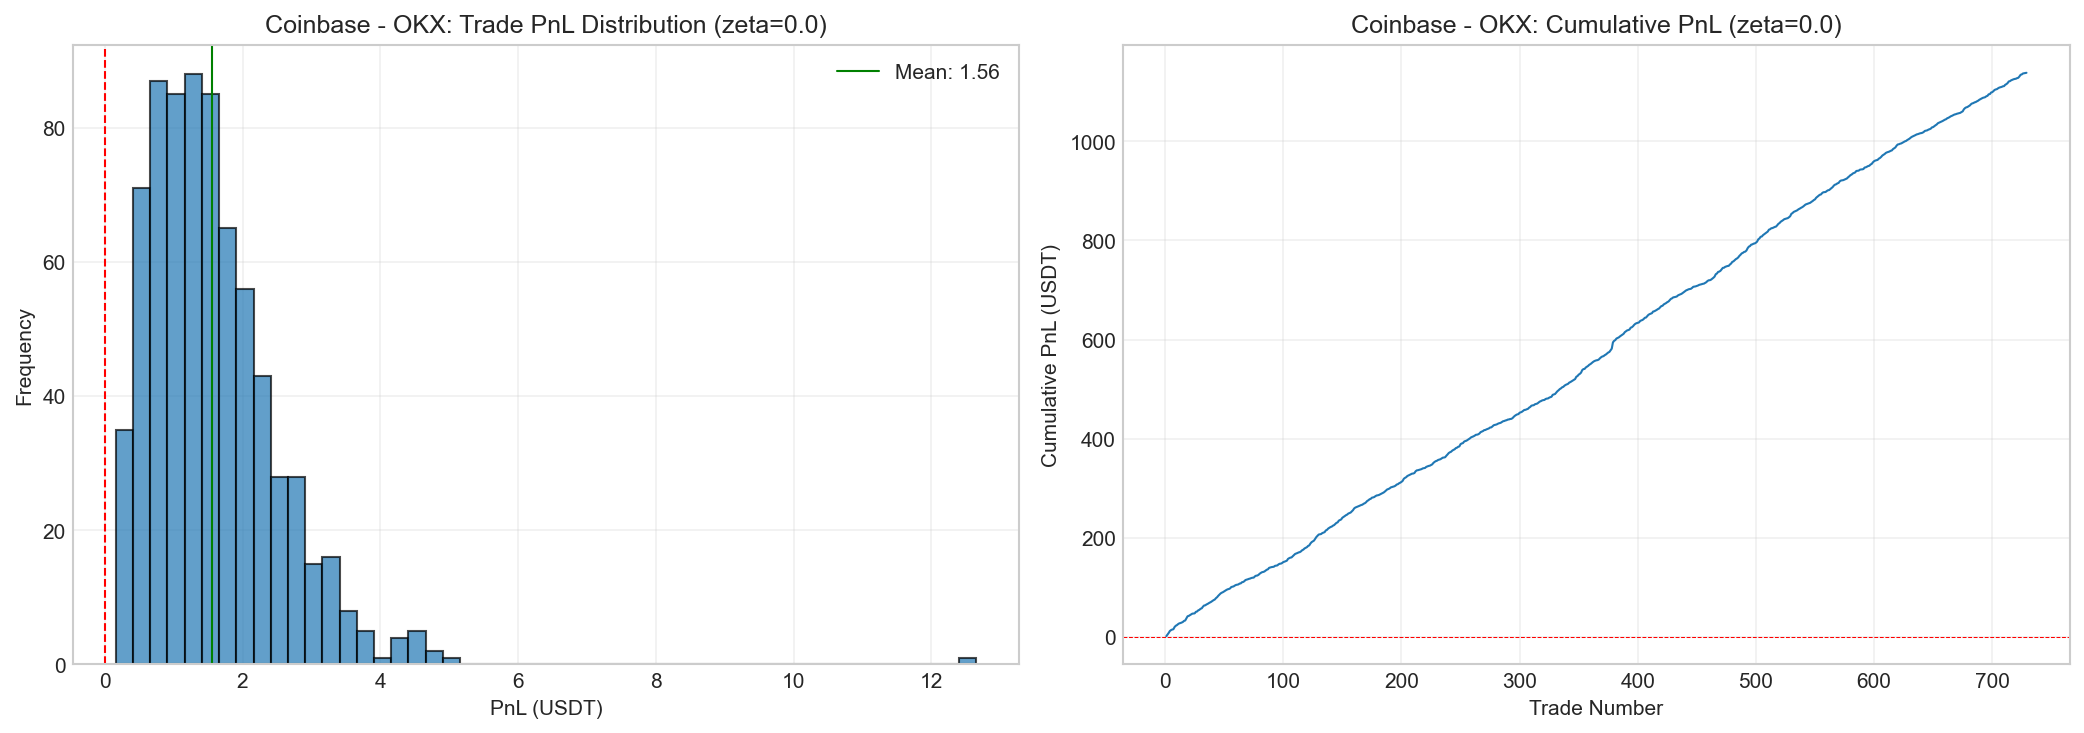

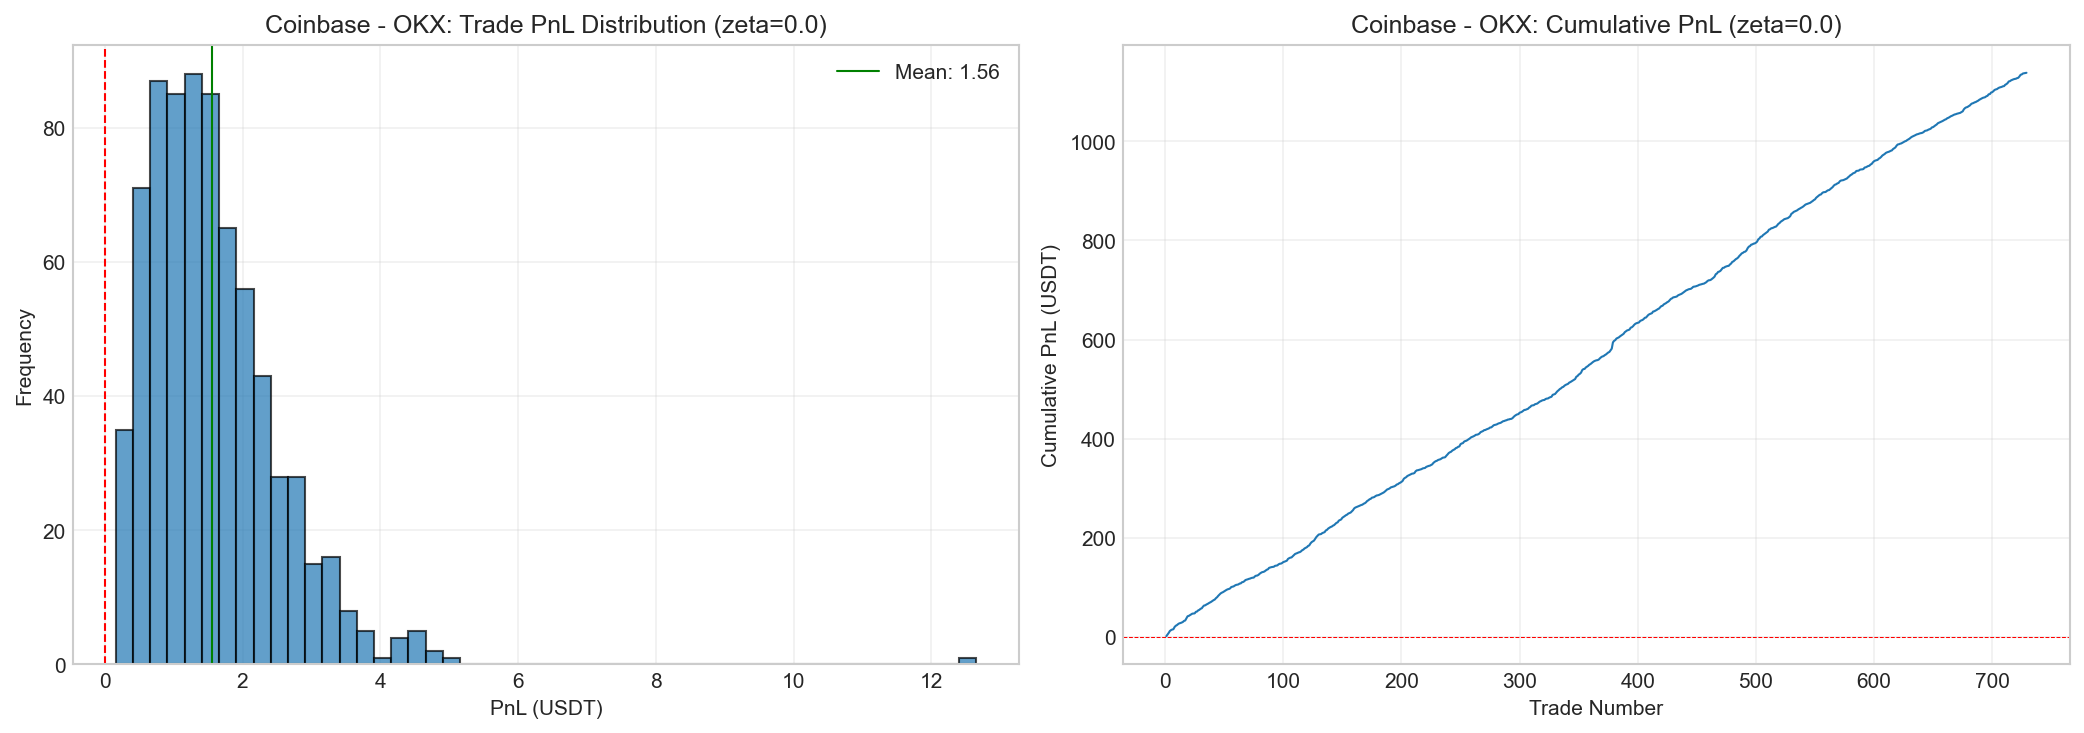

In [79]:
display(Image(filename='outputs/plots/trade_distribution_Binance_Coinbase_zeta0p0.png'))   
display(Image(filename='outputs/plots/trade_distribution_Coinbase_OKX_zeta0p0.png'))   
display(Image(filename='outputs/plots/trade_distribution_Coinbase_OKX_zeta0p0.png'))   

## 6. Conclusions

### Key Findings

In [60]:
# Generate conclusions
print("="*80)
print("CRYPTO SPREAD TRADING ANALYSIS - CONCLUSIONS")
print("="*80)

# Best overall configuration
if len(summary_df) > 0:
    best_row = summary_df.loc[summary_df['Sharpe'].idxmax()]
    print(f"\n1. BEST OVERALL CONFIGURATION:")
    print(f"   Spread Pair: {best_row['Spread Pair']}")
    print(f"   Trading Cost (ζ): {best_row['Zeta']}")
    print(f"   Best Parameters:")
    print(f"     j (exit band): {best_row['j (exit)']:.4f}")
    print(f"     g (entry band): {best_row['g (entry)']:.4f}")
    print(f"     l (stop loss): {best_row['l (stop)']:.4f}")
    print(f"     N (rank): {int(best_row['N'])}")
    print(f"     M (lookback): {int(best_row['M'])}")
    print(f"   Performance:")
    print(f"     Sharpe Ratio: {best_row['Sharpe']:.4f}")
    print(f"     Total Return: {best_row['Return (%)']:.4f}%")
    print(f"     Max Drawdown: {best_row['Max DD (%)']:.2f}%")
    print(f"     Win Rate: {best_row['Win Rate (%)']:.1f}%")

# Trading cost impact
print(f"\n2. TRADING COST IMPACT:")
if 0.0 in summary_df['Zeta'].values and 0.0001 in summary_df['Zeta'].values:
    avg_sharpe_0 = summary_df[summary_df['Zeta'] == 0.0]['Sharpe'].mean()
    avg_sharpe_1 = summary_df[summary_df['Zeta'] == 0.0001]['Sharpe'].mean()
    print(f"   Average Sharpe (ζ=0): {avg_sharpe_0:.4f}")
    print(f"   Average Sharpe (ζ=0.0001): {avg_sharpe_1:.4f}")
    print(f"   Impact: {(avg_sharpe_1-avg_sharpe_0)/abs(avg_sharpe_0)*100:.1f}% change")

# Parameter patterns
print(f"\n3. PARAMETER PATTERNS:")
print(f"   - Entry band (g) typically optimal around: {summary_df['g (entry)'].mean():.2f}")
print(f"   - Exit band (j) typically optimal around: {summary_df['j (exit)'].mean():.2f}")
print(f"   - Stop loss (l) typically optimal around: {summary_df['l (stop)'].mean():.2f}")
print(f"   - Rank (N) typically optimal around: {summary_df['N'].mean():.0f}")
print(f"   - Lookback (M) typically optimal around: {summary_df['M'].mean():.0f}")

print(f"\n4. RECOMMENDATIONS:")
print(f"   - The spread trading strategy shows {'positive' if best_row['Sharpe'] > 0 else 'negative'} risk-adjusted returns")
print(f"   - Trading costs of 1 basis point {'significantly reduce' if avg_sharpe_1 < avg_sharpe_0 * 0.8 else 'moderately affect'} profitability")
print(f"   - The {best_row['Spread Pair']} pair shows the most promising results")

print("\n" + "="*80)

CRYPTO SPREAD TRADING ANALYSIS - CONCLUSIONS

1. BEST OVERALL CONFIGURATION:
   Spread Pair: Binance-Coinbase
   Trading Cost (ζ): 0.0
   Best Parameters:
     j (exit band): 0.4687
     g (entry band): 1.0217
     l (stop loss): 8.9900
     N (rank): 87
     M (lookback): 105
   Performance:
     Sharpe Ratio: 302.4473
     Total Return: 1.3593%
     Max Drawdown: 0.01%
     Win Rate: 95.4%

2. TRADING COST IMPACT:
   Average Sharpe (ζ=0): 206.8295
   Average Sharpe (ζ=0.0001): 111.0036
   Impact: -46.3% change

3. PARAMETER PATTERNS:
   - Entry band (g) typically optimal around: 1.99
   - Exit band (j) typically optimal around: 1.25
   - Stop loss (l) typically optimal around: 9.75
   - Rank (N) typically optimal around: 57
   - Lookback (M) typically optimal around: 101

4. RECOMMENDATIONS:
   - The spread trading strategy shows positive risk-adjusted returns
   - Trading costs of 1 basis point significantly reduce profitability
   - The Binance-Coinbase pair shows the most promisin

In [61]:
# Final summary table
print("\nFINAL RESULTS TABLE:")
print(summary_df.to_string(index=False))


FINAL RESULTS TABLE:
     Spread Pair   Zeta  j (exit)  g (entry)  l (stop)  N   M     Sharpe  Return (%)  Max DD (%)  Win Rate (%)  Trades/Day  Stop Losses
Binance-Coinbase 0.0000  0.468652   1.021656  8.990046 87 105 302.447257    1.359275    0.014683     95.381883       281.5            0
Binance-Coinbase 0.0001  0.923414   1.815279 15.472239 66  97 176.204899    0.503024    0.009720     99.404762        84.0            0
    Coinbase-OKX 0.0001  1.961399   3.405509  6.833450 38 106  45.802216    0.062716    0.005282    100.000000         5.5            0
    Coinbase-OKX 0.0000  1.634438   1.715151  7.686537 38  95 111.211654    0.337100    0.006518    100.000000        47.5            0


Appendix: optimizer.py

In [ ]:
#!/usr/bin/env python
"""
Main script to run crypto spread trading optimization.

Usage:
    uv run python scripts/run_optimization.py
    uv run python scripts/run_optimization.py --n-trials 100
    uv run python scripts/run_optimization.py --pairs Binance-Coinbase --zeta 0.0
    uv run python scripts/run_optimization.py --parallel  # Run pairs in parallel
"""

import argparse
import sys
from pathlib import Path
import json
import pickle
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

# Add src to path
sys.path.insert(0, str(Path(__file__).parent.parent / "src"))

from crypto_spread.config import (
    SPREAD_PAIRS,
    ZETA_VALUES,
    DEFAULT_N_TRIALS,
    OUTPUT_DIR,
    DATA_DIR,
)
from crypto_spread.data_loader import (
    load_and_align_all_data,
    get_spread_pair_data,
)
from crypto_spread.signals import compute_all_signals
from crypto_spread.backtest import run_backtest
from crypto_spread.optimizer import (
    run_optimization,
    print_optimization_summary,
    get_best_trial_metrics,
    trials_to_dataframe,
)
from crypto_spread.visualization import (
    save_all_plots,
    generate_summary_report,
)


def parse_args():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser(
        description="Run crypto spread trading optimization"
    )
    parser.add_argument(
        "--n-trials",
        type=int,
        default=DEFAULT_N_TRIALS,
        help=f"Number of optimization trials (default: {DEFAULT_N_TRIALS})",
    )
    parser.add_argument(
        "--pairs",
        nargs="+",
        default=None,
        help="Spread pairs to optimize (e.g., Binance-Coinbase Binance-OKX)",
    )
    parser.add_argument(
        "--zeta",
        nargs="+",
        type=float,
        default=None,
        help="Trading cost values (e.g., 0.0 0.0001)",
    )
    parser.add_argument(
        "--no-plots",
        action="store_true",
        help="Skip generating plots",
    )
    parser.add_argument(
        "--seed",
        type=int,
        default=42,
        help="Random seed for reproducibility",
    )
    parser.add_argument(
        "--save-pickle",
        action="store_true",
        help="Save full results (including BacktestResult with trades) as pickle file",
    )
    parser.add_argument(
        "--parallel",
        action="store_true",
        help="Run optimizations for different pairs in parallel",
    )
    parser.add_argument(
        "--workers",
        type=int,
        default=None,
        help="Number of parallel workers (default: number of CPU cores)",
    )
    return parser.parse_args()


def run_single_optimization(
    spread_pair: tuple,
    zeta: float,
    aligned_data: pd.DataFrame,
    n_trials: int,
    seed: int,
    no_plots: bool,
    run_id: str,
) -> dict:
    """
    Run optimization for a single pair/zeta combination.

    Returns dict with results for this configuration.
    """
    pair_name = f"{spread_pair[0]}-{spread_pair[1]}"

    try:
        pair_data = get_spread_pair_data(aligned_data, spread_pair[0], spread_pair[1])
    except ValueError as e:
        print(f"[{run_id}] Skipping {pair_name}: {e}")
        return None

    timestamps = pair_data["ts"]
    price_a = pair_data["price_a"]
    price_b = pair_data["price_b"]

    print(f"[{run_id}] Starting: {pair_name}, zeta={zeta}")

    # Run optimization
    opt_result = run_optimization(
        price_a=price_a,
        price_b=price_b,
        timestamps=timestamps,
        spread_pair=spread_pair,
        zeta=zeta,
        n_trials=n_trials,
        seed=seed,
        show_progress=False,  # Disable progress bar in parallel mode
    )

    # Extract serializable data (Study object can't cross process boundary)
    if opt_result.n_completed > 0:
        metrics = get_best_trial_metrics(opt_result.study)
        best_params = opt_result.best_params
    else:
        metrics = {}
        best_params = {}

    result = {
        "spread_pair": spread_pair,
        "zeta": zeta,
        "best_params": best_params,
        "best_value": opt_result.best_value,
        "n_completed": opt_result.n_completed,
        "n_pruned": opt_result.n_pruned,
        "metrics": metrics,
        "backtest_result": None,
    }

    # Run backtest with best parameters if we have them
    if opt_result.n_completed > 0:
        backtest_result = run_backtest(
            price_a=price_a,
            price_b=price_b,
            timestamps=timestamps,
            j=best_params["j"],
            g=best_params["g"],
            l=best_params["l"],
            N=best_params["N"],
            M=best_params["M"],
            zeta=zeta,
        )
        result["backtest_result"] = backtest_result

        # Generate plots if requested
        if not no_plots:
            signals = compute_all_signals(
                price_a, price_b, best_params["N"], best_params["M"]
            )
            save_all_plots(
                study=opt_result.study,
                backtest_result=backtest_result,
                timestamps=timestamps,
                signals_df=signals,
                spread_pair=spread_pair,
                zeta=zeta,
                output_dir=OUTPUT_DIR / "plots",
            )

    sharpe_str = f"{opt_result.best_value:.4f}" if opt_result.n_completed > 0 else "N/A"
    print(f"[{run_id}] Completed: {pair_name}, zeta={zeta} (Sharpe: {sharpe_str})")

    return result


def run_seeded_optimization_worker(
    spread_pair: tuple,
    zeta: float,
    seed_params: dict,
    aligned_data: pd.DataFrame,
    n_trials: int,
    run_id: str,
) -> dict:
    """Run seeded optimization for a single configuration."""
    import optuna
    from crypto_spread.config import MIN_TRADES_PER_DAY

    pair_name = f"{spread_pair[0]}-{spread_pair[1]}"

    try:
        pair_data = get_spread_pair_data(aligned_data, spread_pair[0], spread_pair[1])
    except ValueError as e:
        print(f"[{run_id}] Skipping {pair_name}: {e}")
        return None

    def objective(trial):
        j = trial.suggest_float("j", max(0.01, seed_params['j'] * 0.5), seed_params['j'] * 2.0)
        g_min = j + 0.01
        g = trial.suggest_float("g", max(g_min, seed_params['g'] * 0.5), seed_params['g'] * 2.0)
        l_min = g + 0.01
        l = trial.suggest_float("l", max(l_min, seed_params['l'] * 0.5), seed_params['l'] * 2.0)
        N = trial.suggest_int("N", max(1, seed_params['N'] - 30), min(100, seed_params['N'] + 30))
        M = trial.suggest_int("M", max(N, seed_params['M'] - 100), min(1000, seed_params['M'] + 100))

        try:
            result = run_backtest(
                price_a=pair_data['price_a'],
                price_b=pair_data['price_b'],
                timestamps=pair_data['ts'],
                j=j, g=g, l=l, N=N, M=M,
                zeta=zeta,
            )
            if result.trades_per_day < MIN_TRADES_PER_DAY:
                raise optuna.TrialPruned()
            trial.set_user_attr("max_drawdown", result.max_drawdown)
            trial.set_user_attr("total_return", result.total_return)
            trial.set_user_attr("win_rate", result.win_rate)
            trial.set_user_attr("trades_per_day", result.trades_per_day)
            trial.set_user_attr("stop_loss_count", result.stop_loss_count)
            return result.sharpe_ratio
        except:
            raise optuna.TrialPruned()

    print(f"[{run_id}] Seeded search: {pair_name}, zeta={zeta}")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    n_completed = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
    if n_completed == 0:
        return None

    best_params = study.best_params
    backtest_result = run_backtest(
        price_a=pair_data['price_a'],
        price_b=pair_data['price_b'],
        timestamps=pair_data['ts'],
        **best_params,
        zeta=zeta,
    )

    return {
        "spread_pair": spread_pair,
        "zeta": zeta,
        "best_params": best_params,
        "best_value": study.best_value,
        "n_completed": n_completed,
        "n_pruned": len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]),
        "metrics": {
            "total_return": backtest_result.total_return,
            "max_drawdown": backtest_result.max_drawdown,
            "win_rate": backtest_result.win_rate,
            "trades_per_day": backtest_result.trades_per_day,
            "stop_loss_count": backtest_result.stop_loss_count,
        },
        "backtest_result": backtest_result,
    }


def main():
    """Main entry point."""
    args = parse_args()

    # Create output directories
    (OUTPUT_DIR / "plots").mkdir(parents=True, exist_ok=True)
    (OUTPUT_DIR / "results").mkdir(parents=True, exist_ok=True)

    print("=" * 80)
    print("CRYPTO SPREAD TRADING OPTIMIZATION")
    print("=" * 80)

    # Load and align data
    print("\n[1/4] Loading and aligning data...")
    aligned_data = load_and_align_all_data(DATA_DIR)

    # Determine which pairs to optimize
    if args.pairs:
        pairs = []
        for p in args.pairs:
            parts = p.split("-")
            if len(parts) == 2:
                pairs.append((parts[0], parts[1]))
            else:
                print(f"Warning: Invalid pair format '{p}', skipping")
    else:
        pairs = SPREAD_PAIRS

    # Determine zeta values
    zeta_values = args.zeta if args.zeta else ZETA_VALUES

    print(f"\nSpread pairs: {pairs}")
    print(f"Zeta values: {zeta_values}")
    print(f"Trials per optimization: {args.n_trials}")
    print(f"Parallel mode: {args.parallel}")

    # Store all results
    all_results = {}
    all_backtest_results = {}

    # Build list of all configurations to run
    configs = []
    for spread_pair in pairs:
        for zeta in zeta_values:
            configs.append((spread_pair, zeta))

    total_runs = len(configs)
    print(f"Total configurations: {total_runs}")

    # Run optimization for each pair and zeta
    print("\n[2/4] Running optimizations...")

    if args.parallel and total_runs > 1:
        # Parallel execution
        n_workers = args.workers or min(mp.cpu_count(), total_runs)
        print(f"Using {n_workers} parallel workers")

        with ProcessPoolExecutor(max_workers=n_workers) as executor:
            futures = {}
            for i, (spread_pair, zeta) in enumerate(configs, 1):
                run_id = f"{i}/{total_runs}"
                future = executor.submit(
                    run_single_optimization,
                    spread_pair,
                    zeta,
                    aligned_data,
                    args.n_trials,
                    args.seed,
                    args.no_plots,
                    run_id,
                )
                futures[future] = (spread_pair, zeta)

            for future in as_completed(futures):
                spread_pair, zeta = futures[future]
                try:
                    result = future.result()
                    if result:
                        key = (result["spread_pair"], result["zeta"])
                        # Store serialized optimization data (dict format for parallel mode)
                        all_results[key] = {
                            "best_params": result["best_params"],
                            "best_value": result["best_value"],
                            "n_completed": result["n_completed"],
                            "n_pruned": result["n_pruned"],
                            "metrics": result["metrics"],
                        }
                        if result["backtest_result"]:
                            all_backtest_results[key] = result["backtest_result"]
                except Exception as e:
                    pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
                    print(f"ERROR processing {pair_name}, zeta={zeta}: {e}")
    else:
        # Sequential execution
        for run_count, (spread_pair, zeta) in enumerate(configs, 1):
            pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
            print(f"\n--- Run {run_count}/{total_runs}: {pair_name}, zeta={zeta} ---")

            try:
                pair_data = get_spread_pair_data(aligned_data, spread_pair[0], spread_pair[1])
            except ValueError as e:
                print(f"Skipping {spread_pair}: {e}")
                continue

            timestamps = pair_data["ts"]
            price_a = pair_data["price_a"]
            price_b = pair_data["price_b"]

            # Run optimization
            opt_result = run_optimization(
                price_a=price_a,
                price_b=price_b,
                timestamps=timestamps,
                spread_pair=spread_pair,
                zeta=zeta,
                n_trials=args.n_trials,
                seed=args.seed,
                show_progress=True,
            )

            # Store results
            all_results[(spread_pair, zeta)] = opt_result

            # Print summary
            print_optimization_summary(opt_result)

            # Run backtest with best parameters if we have them
            if opt_result.n_completed > 0:
                best_params = opt_result.best_params
                backtest_result = run_backtest(
                    price_a=price_a,
                    price_b=price_b,
                    timestamps=timestamps,
                    j=best_params["j"],
                    g=best_params["g"],
                    l=best_params["l"],
                    N=best_params["N"],
                    M=best_params["M"],
                    zeta=zeta,
                )
                all_backtest_results[(spread_pair, zeta)] = backtest_result

                # Generate plots if requested
                if not args.no_plots:
                    signals = compute_all_signals(
                        price_a, price_b, best_params["N"], best_params["M"]
                    )
                    save_all_plots(
                        study=opt_result.study,
                        backtest_result=backtest_result,
                        timestamps=timestamps,
                        signals_df=signals,
                        spread_pair=spread_pair,
                        zeta=zeta,
                        output_dir=OUTPUT_DIR / "plots",
                    )

    # Phase 2: Seeded re-optimization if one zeta found better params
    print("\n[2.5/4] Seeded re-optimization for inconsistent results...")

    def is_dict_result(result):
        return isinstance(result, dict)

    seeded_configs = []
    for spread_pair in pairs:
        pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
        result_0 = all_results.get((spread_pair, 0.0))
        result_1 = all_results.get((spread_pair, 0.0001))

        if result_0 is None or result_1 is None:
            continue

        sharpe_0 = (result_0["best_value"] if is_dict_result(result_0) else result_0.best_value) if (result_0.get("n_completed", 0) if is_dict_result(result_0) else result_0.n_completed) > 0 else float('-inf')
        sharpe_1 = (result_1["best_value"] if is_dict_result(result_1) else result_1.best_value) if (result_1.get("n_completed", 0) if is_dict_result(result_1) else result_1.n_completed) > 0 else float('-inf')

        if sharpe_1 > sharpe_0:
            seed_params = result_1["best_params"] if is_dict_result(result_1) else result_1.best_params
            seeded_configs.append((spread_pair, 0.0, seed_params))
            print(f"  {pair_name}: zeta=0.0001 found better params ({sharpe_1:.2f} vs {sharpe_0:.2f}), will re-search")

    if seeded_configs:
        if args.parallel and len(seeded_configs) > 1:
            n_workers = args.workers or min(mp.cpu_count(), len(seeded_configs))
            with ProcessPoolExecutor(max_workers=n_workers) as executor:
                futures = {}
                for i, (spread_pair, zeta, seed_params) in enumerate(seeded_configs, 1):
                    run_id = f"seeded-{i}/{len(seeded_configs)}"
                    future = executor.submit(
                        run_seeded_optimization_worker,
                        spread_pair, zeta, seed_params, aligned_data, 30, run_id
                    )
                    futures[future] = (spread_pair, zeta)

                for future in as_completed(futures):
                    spread_pair, zeta = futures[future]
                    try:
                        result = future.result()
                        if result:
                            key = (result["spread_pair"], result["zeta"])
                            all_results[key] = {
                                "best_params": result["best_params"],
                                "best_value": result["best_value"],
                                "n_completed": result["n_completed"],
                                "n_pruned": result["n_pruned"],
                                "metrics": result["metrics"],
                            }
                            if result["backtest_result"]:
                                all_backtest_results[key] = result["backtest_result"]
                    except Exception as e:
                        print(f"ERROR in seeded optimization: {e}")
        else:
            for spread_pair, zeta, seed_params in seeded_configs:
                result = run_seeded_optimization_worker(
                    spread_pair, zeta, seed_params, aligned_data, 30,
                    f"seeded-{spread_pair[0]}-{spread_pair[1]}"
                )
                if result:
                    key = (result["spread_pair"], result["zeta"])
                    all_results[key] = {
                        "best_params": result["best_params"],
                        "best_value": result["best_value"],
                        "n_completed": result["n_completed"],
                        "n_pruned": result["n_pruned"],
                        "metrics": result["metrics"],
                    }
                    if result["backtest_result"]:
                        all_backtest_results[key] = result["backtest_result"]

    # Save results
    print("\n[3/4] Saving results...")

    # Generate and save summary report
    # Note: generate_summary_report expects OptimizationResult objects, so we skip it for parallel mode dicts
    if all_results and not is_dict_result(next(iter(all_results.values()))):
        report = generate_summary_report(
            all_results,
            output_path=OUTPUT_DIR / "results" / "optimization_summary.txt",
        )
        print(report)
    else:
        # For parallel mode, generate a simple summary
        summary_lines = ["=" * 60, "OPTIMIZATION SUMMARY (Parallel Mode)", "=" * 60, ""]
        for key, result in all_results.items():
            spread_pair, zeta = key
            pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
            if result["n_completed"] > 0:
                summary_lines.append(f"{pair_name} (zeta={zeta}): Sharpe={result['best_value']:.4f}")
            else:
                summary_lines.append(f"{pair_name} (zeta={zeta}): No completed trials")
        summary_lines.append("=" * 60)
        report = "\n".join(summary_lines)
        with open(OUTPUT_DIR / "results" / "optimization_summary.txt", "w") as f:
            f.write(report)
        print(report)

    # Save detailed results as JSON
    results_json = {}
    for key, opt_result in all_results.items():
        spread_pair, zeta = key
        pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
        key_str = f"{pair_name}_zeta{zeta}"

        if is_dict_result(opt_result):
            # Parallel mode: already a dict
            if opt_result["n_completed"] > 0:
                results_json[key_str] = {
                    "spread_pair": list(spread_pair),
                    "zeta": zeta,
                    "best_params": opt_result["best_params"],
                    "best_sharpe": opt_result["best_value"],
                    "n_completed": opt_result["n_completed"],
                    "n_pruned": opt_result["n_pruned"],
                    "metrics": {k: float(v) if isinstance(v, (int, float)) else v for k, v in opt_result["metrics"].items()},
                }
        else:
            # Sequential mode: OptimizationResult object
            if opt_result.n_completed > 0:
                metrics = get_best_trial_metrics(opt_result.study)
                results_json[key_str] = {
                    "spread_pair": list(spread_pair),
                    "zeta": zeta,
                    "best_params": opt_result.best_params,
                    "best_sharpe": opt_result.best_value,
                    "n_completed": opt_result.n_completed,
                    "n_pruned": opt_result.n_pruned,
                    "metrics": {k: float(v) if isinstance(v, (int, float)) else v for k, v in metrics.items()},
                }

    with open(OUTPUT_DIR / "results" / "optimization_results.json", "w") as f:
        json.dump(results_json, f, indent=2)
    print(f"Saved: {OUTPUT_DIR / 'results' / 'optimization_results.json'}")

    # Save full results as pickle if requested
    if args.save_pickle:
        pickle_data = {
            "optimization_results": all_results,
            "backtest_results": all_backtest_results,
        }
        pickle_path = OUTPUT_DIR / "results" / "optimization_results.pkl"
        with open(pickle_path, "wb") as f:
            pickle.dump(pickle_data, f)
        print(f"Saved: {pickle_path}")

    # Save trials dataframe for each study (only available in sequential mode)
    for key, opt_result in all_results.items():
        spread_pair, zeta = key
        pair_name = f"{spread_pair[0]}_{spread_pair[1]}"
        zeta_str = f"zeta{zeta}".replace(".", "p")

        # Skip if parallel mode (dict format - no Study object available)
        if is_dict_result(opt_result):
            continue

        trials_df = trials_to_dataframe(opt_result.study)
        if not trials_df.empty:
            csv_path = OUTPUT_DIR / "results" / f"trials_{pair_name}_{zeta_str}.csv"
            trials_df.to_csv(csv_path, index=False)
            print(f"Saved: {csv_path}")

    print("\n[4/4] Optimization complete!")
    print(f"\nResults saved to: {OUTPUT_DIR}")

    # Print final comparison table
    print("\n" + "=" * 80)
    print("FINAL COMPARISON")
    print("=" * 80)
    print(f"{'Spread Pair':<25} {'Zeta':<10} {'Sharpe':<10} {'Return %':<10} {'Trades/Day':<12}")
    print("-" * 80)

    for key, opt_result in all_results.items():
        spread_pair, zeta = key
        pair_name = f"{spread_pair[0]}-{spread_pair[1]}"

        if is_dict_result(opt_result):
            # Parallel mode: dict format
            if opt_result["n_completed"] > 0:
                metrics = opt_result["metrics"]
                sharpe = opt_result["best_value"]
                ret = metrics.get("total_return", 0) * 100
                tpd = metrics.get("trades_per_day", 0)
                print(f"{pair_name:<25} {zeta:<10.4f} {sharpe:<10.4f} {ret:<10.4f} {tpd:<12.1f}")
            else:
                print(f"{pair_name:<25} {zeta:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<12}")
        else:
            # Sequential mode: OptimizationResult object
            if opt_result.n_completed > 0:
                metrics = get_best_trial_metrics(opt_result.study)
                sharpe = opt_result.best_value
                ret = metrics.get("total_return", 0) * 100
                tpd = metrics.get("trades_per_day", 0)
                print(f"{pair_name:<25} {zeta:<10.4f} {sharpe:<10.4f} {ret:<10.4f} {tpd:<12.1f}")
            else:
                print(f"{pair_name:<25} {zeta:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<12}")

    print("=" * 80)


if __name__ == "__main__":
    main()